In [1]:
%matplotlib inline
import os
import pandas as pd
from fbprophet import Prophet
import json
from datetime import datetime

In [2]:
def get_datetime_from_string(s, keep_utc=True):
    if keep_utc:
        return datetime.strptime(s + "00", '%Y-%m-%d %H:%M:%S%z')
    else:
        return datetime.strptime(s[:-3], '%Y-%m-%d %H:%M:%S')

In [3]:
df = pd.read_csv(os.path.join('..', 'data', 'processed', 'Tankstellen_states.csv'))
df.head()

,Unnamed: 0,id,Name,Company,Street,House_Number,Postalcode,City,Lat,Long,State
0,0,1,star Tankstelle,STAR,Listlandstrasse,16,25992,List,55.015890,8.429530,Schleswig-Holstein
1,1,2,Esso Tankstelle,ESSO,TRIFT 2,,25980,WESTERLAND,54.907468,8.308741,Schleswig-Holstein
2,2,3,"SYLT, TRIFT",Shell,TRIFT 7,NaN,25980,SYLT,54.904400,8.310700,Schleswig-Holstein
3,3,4,DEXX-Station 188,DEXX,Dorfstr.,19,25927,Aventoft,54.901300,8.822810,Schleswig-Holstein
4,4,5,team Tankautomat Hesbüll,Raiffeisen,Raiffeisenstr.,1,25927,Hesbüll,54.900900,8.810690,Schleswig-Holstein


In [4]:
abbreviations = {'Baden-Württemberg': 'BW', 'Bayern': 'BY', 'Berlin': 'BE', 'Brandenburg': 'BB', 'Bremen': 'HB', 'Hamburg': 'HH', 'Hessen': 'HE', 'Mecklenburg-Vorpommern': 'MV', 'Niedersachsen': 'NI', 'Nordrhein-Westfalen': 'NW', 'Rheinland-Pfalz': 'RP', 'Saarland': 'SL', 'Sachsen': 'SN', 'Sachsen-Anhalt': 'ST', 'Schleswig-Holstein': 'SH', 'Thüringen': 'TH', 'unknown': 'unknown'}

In [5]:
df['State'] = df.State.apply(lambda x : abbreviations[x])
df.head()

,Unnamed: 0,id,Name,Company,Street,House_Number,Postalcode,City,Lat,Long,State
0,0,1,star Tankstelle,STAR,Listlandstrasse,16,25992,List,55.015890,8.429530,SH
1,1,2,Esso Tankstelle,ESSO,TRIFT 2,,25980,WESTERLAND,54.907468,8.308741,SH
2,2,3,"SYLT, TRIFT",Shell,TRIFT 7,NaN,25980,SYLT,54.904400,8.310700,SH
3,3,4,DEXX-Station 188,DEXX,Dorfstr.,19,25927,Aventoft,54.901300,8.822810,SH
4,4,5,team Tankautomat Hesbüll,Raiffeisen,Raiffeisenstr.,1,25927,Hesbüll,54.900900,8.810690,SH


In [6]:
GAS_PRICE_PATH = os.path.join('..', 'data', 'raw', 'input_data', 'Eingabedaten', 'Benzinpreise')
GAS_STATION_1_PATH = os.path.join(GAS_PRICE_PATH, '1.csv')
df_gas_station = pd.read_csv(GAS_STATION_1_PATH, names=['Timestamp', 'Price'], sep=';', )
df_gas_station.head()

,Timestamp,Price
0,2014-06-09 00:02:01+02,1659
1,2014-06-10 17:14:01+02,1669
2,2014-06-11 17:14:01+02,1669
3,2014-06-12 17:14:01+02,1679
4,2014-06-13 17:14:01+02,1689


In [7]:
gas_station_row = df.iloc[0, :]

In [8]:
# Add vacation information
years = []
for year in range(2014, 2019):
    year_content = open(os.path.join('..', 'data', 'external', "vacations_{}_SH.json".format(year))).read()
    year_dict = json.loads(year_content)
    years.extend([datetime.strptime(d['Datum'].split('T00:00:00')[0], '%Y-%m-%d') for d in year_dict])
df_vacations = pd.DataFrame({
  'holiday': 'vacations',
  'ds': pd.to_datetime(years),
})
df_vacations.head()

,ds,holiday
0,2014-01-01,vacations
1,2014-04-18,vacations
2,2014-04-20,vacations
3,2014-04-21,vacations
4,2014-05-01,vacations


In [9]:
# Add holiday information
years = []
for year in range(2014, 2019):
    year_content = open(os.path.join('..', 'data', 'external', "holidays_{}.json".format(year))).read()
    year_dict = json.loads(year_content)
    for day in year_dict['SH'].keys():
        years.append(year_dict['SH'][day]['datum'])
df_holidays = pd.DataFrame({
  'holiday': 'holiday',
  'ds': pd.to_datetime(years),
})
df_holidays.head()

,ds,holiday
0,2014-12-25,holiday
1,2014-04-21,holiday
2,2014-10-03,holiday
3,2014-06-09,holiday
4,2014-01-01,holiday


In [10]:
holidays_df = pd.concat((df_holidays, df_vacations))
m = Prophet(holidays=holidays_df)
df_fb = df_gas_station.copy()
df_fb['y'] = df_fb['Price']
df_fb['ds'] = df_fb['Timestamp'].apply(lambda x : get_datetime_from_string(str(x), keep_utc=False))
df_fb.drop(['Timestamp', 'Price'], inplace=True, axis=1)
m.fit(df_fb)

In [11]:
future = m.make_future_dataframe(periods=31)
future.tail()

,ds
6686,2017-10-18 23:03:06
6687,2017-10-19 23:03:06
6688,2017-10-20 23:03:06
6689,2017-10-21 23:03:06
6690,2017-10-22 23:03:06


In [12]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
6686,2017-10-18 23:03:06,1454.743653,1416.396468,1488.733827
6687,2017-10-19 23:03:06,1456.025690,1419.874351,1488.361128
6688,2017-10-20 23:03:06,1456.298671,1420.744429,1489.486961
6689,2017-10-21 23:03:06,1455.568044,1417.723968,1492.401789
6690,2017-10-22 23:03:06,1456.323983,1417.583493,1492.822521


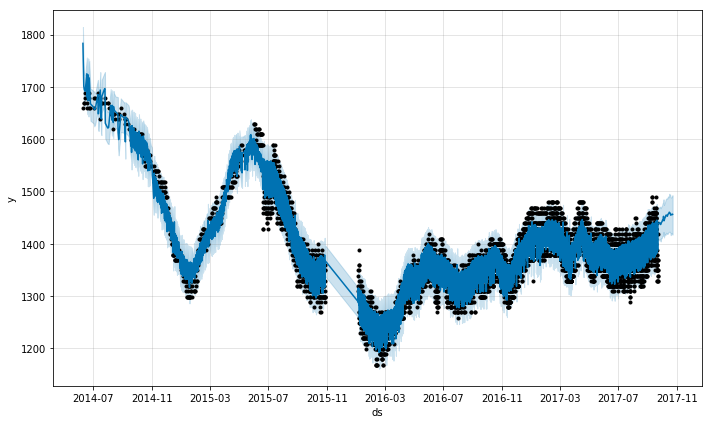

In [13]:
m.plot(forecast);

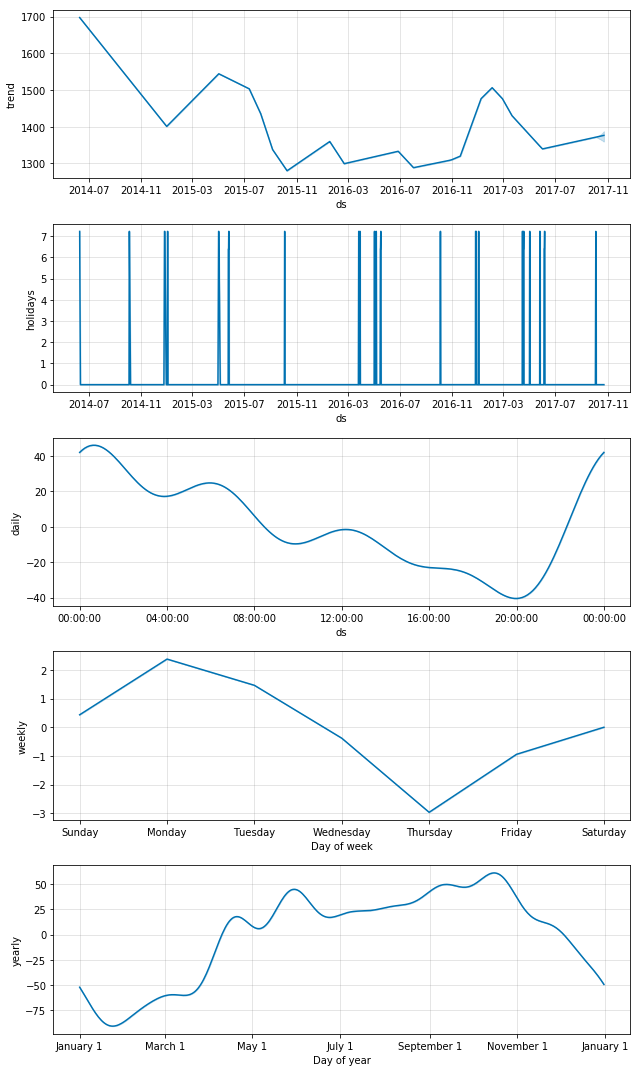

In [14]:
m.plot_components(forecast);